In [7]:
import matplotlib.pyplot as plt

In [8]:
sequential_time = {
    64: 965.394,
    128: 788.034,
    256: 674.394,
    512: 618.048
}

parallel_time = {
    '2 a100 dp': {
        'gpu_num': 2,
        64: 874.374,
        128: 682.0,
        256: 460.76,
        512: 363.6,
    },
    '2 a100 ddp': {
        'gpu_num': 2,
        64: 896.949,
        128: 744.043,
        256: 680.083,
        512: 657.278,
    },
    '2 a100 fsdp': {
        'gpu_num': 2,
        64: 2098.389,
        128: 1227.384,
        256: 776.372,
        512: 710.373,
    },
    '4 a100 dp': {
        'gpu_num': 4,
        64: 1693.874,
        128: 811.382,
        256: 436.037,
        512: 276.498,
    },
    '4 a100 ddp': {
        'gpu_num': 4,
        64: 598.384,
        128: 487.802,
        256: 450.201,
        512: 443.023,
    },
    '4 a100 fsdp': {
        'gpu_num': 4,
        64: 1280.383,
        128: 877.287,
        256: 569.483,
        512: 489.384,
    },
    '8 a100 dp': {
        'gpu_num': 8,
        64: 2681.382,
        128: 1322.384,
        256: 673.282,
        512: 339.242,
    },
    '8 a100 ddp': {
        'gpu_num': 8,
        64: 570.473,
        128: 471.384,
        256: 438.392,
        512: 431.234,
    },
    '8 a100 fsdp': {
        'gpu_num': 8,
        64: 1021.382,
        128: 677.387,
        256: 529.384,
        512: 599.483,
    },
}


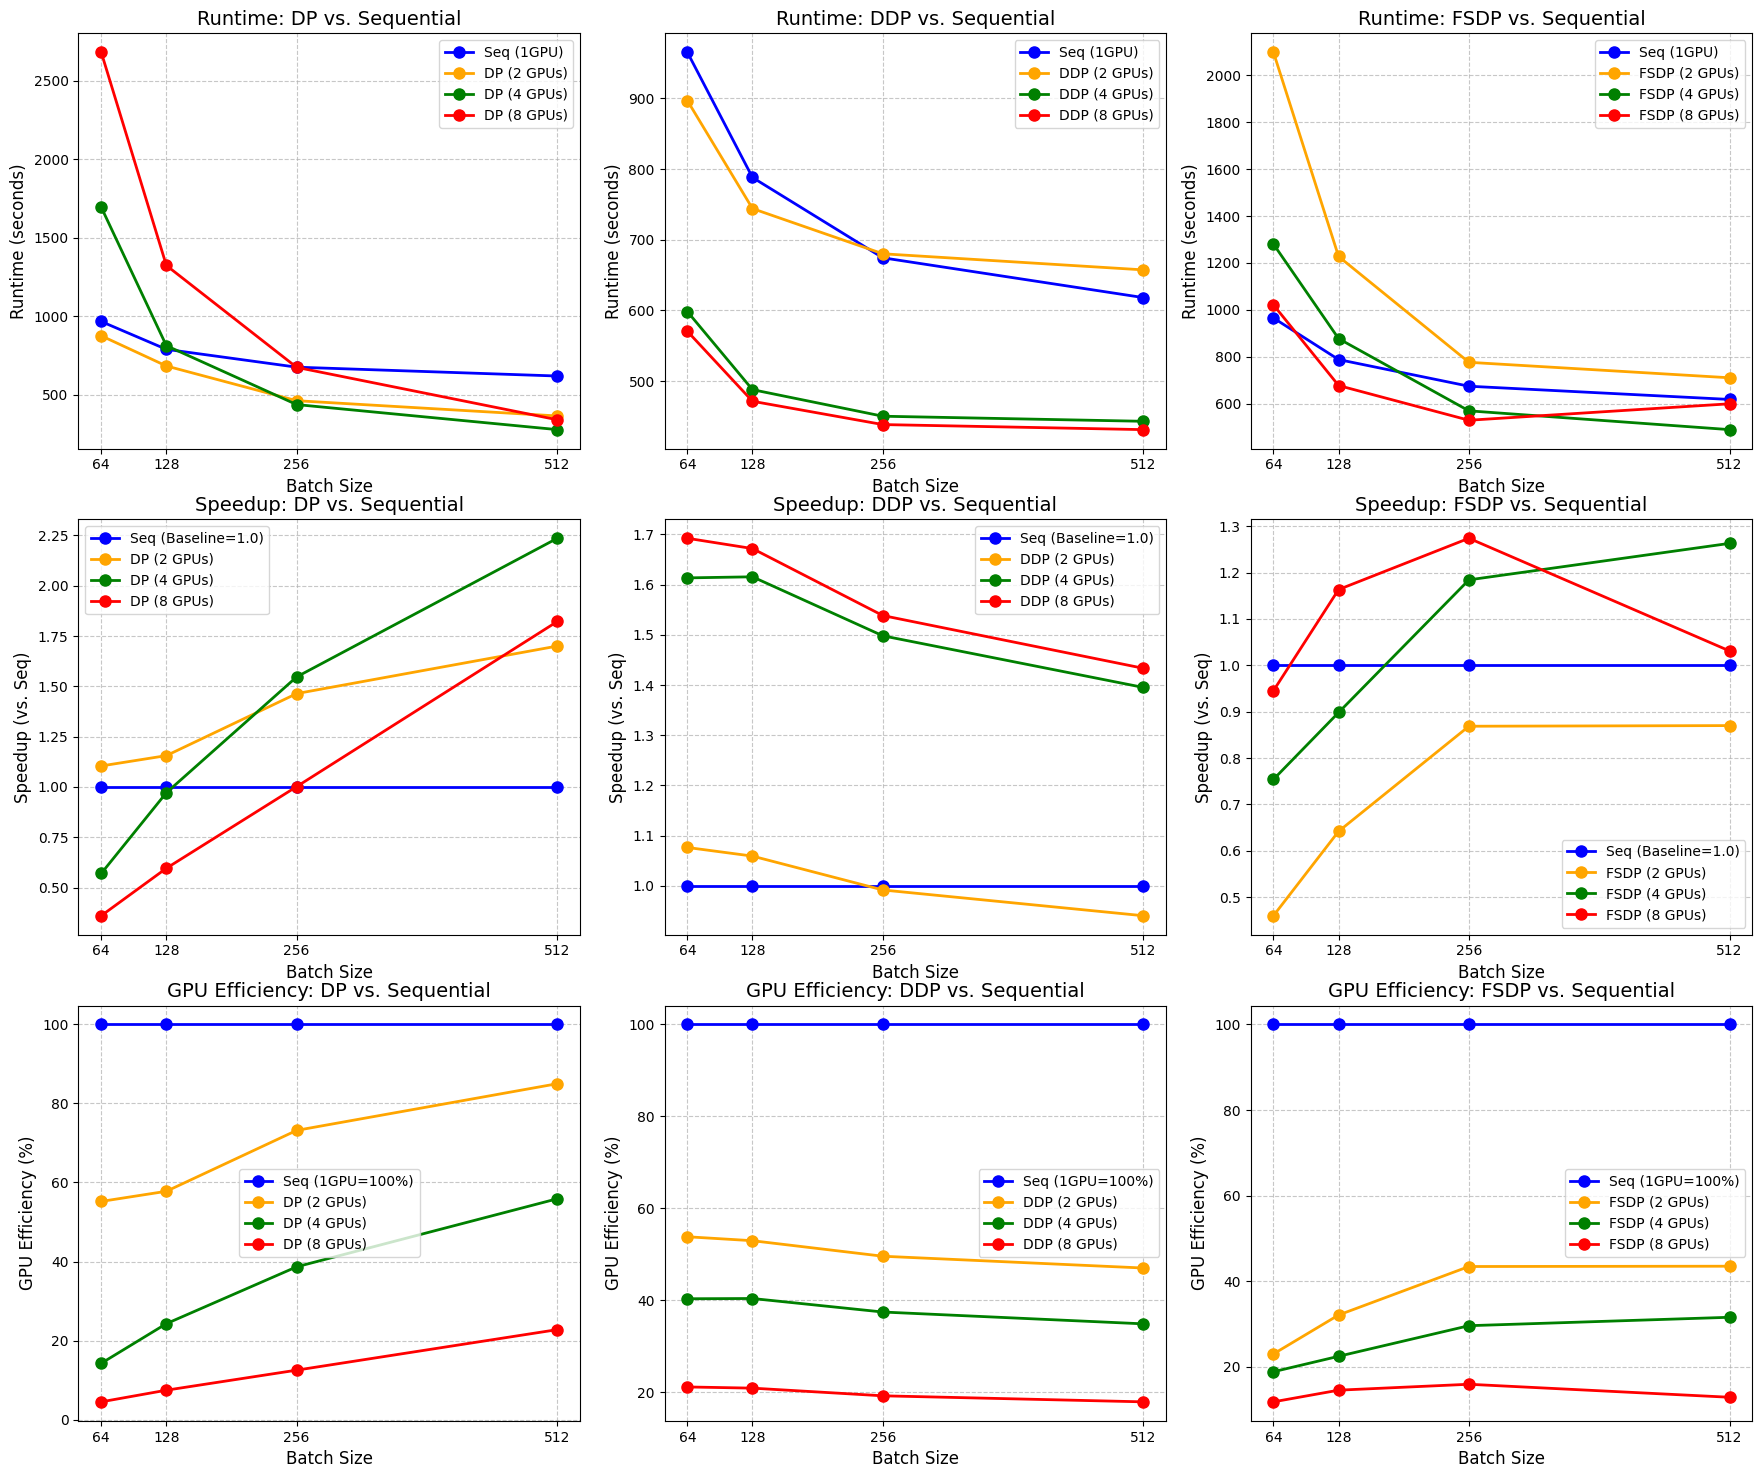

In [9]:
# Which GPU variants each approach actually has in your data
approach_gpu_variants = {
    "dp":   [2, 4, 8],
    "ddp":  [2, 4, 8],
    "fsdp": [2, 4, 8]
}

# For labeling in legends and titles
approach_labels = {
    "dp":   "DP",
    "ddp":  "DDP",
    "fsdp": "FSDP"
}

# Some color/style choices (feel free to modify as needed)
colors = ["orange", "green", "red", "purple", "magenta"]  # used in a cycle for lines
line_styles = ["-", "-", "-", "-"]

batch_sizes = [64, 128, 256, 512]

def get_parallel_time(approach, gpu_count, bs):
    """
    Safely returns the parallel time for (gpu_count a100 approach) at batch size bs.
    Returns None if data doesn't exist.
    """
    dict_key = f"{gpu_count} a100 {approach}"
    if dict_key not in parallel_time:
        return None
    if bs not in parallel_time[dict_key]:
        return None
    return parallel_time[dict_key][bs]

# 创建一个3x3的子图布局
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.tight_layout(pad=3.0)

# 遍历每种方法
for col, approach in enumerate(approach_gpu_variants.keys()):
    gpu_list = approach_gpu_variants[approach]
    
    # 1) RUNTIME chart - 第一行
    ax = axes[0, col]
    # Always plot sequential as the baseline
    ax.plot(
        batch_sizes,
        [sequential_time[bs] for bs in batch_sizes],
        label="Seq (1GPU)",
        linestyle="-",
        marker='o',
        linewidth=2,
        markersize=8,
        color="blue"
    )
    
    color_idx = 0
    for idx, gpu_count in enumerate(gpu_list):
        times = []
        for bs in batch_sizes:
            t = get_parallel_time(approach, gpu_count, bs)
            if t is None:
                break  # skip if missing data
            times.append(t)
        if len(times) == len(batch_sizes):  # means we have full data for these batch sizes
            ax.plot(
                batch_sizes,
                times,
                label=f"{approach_labels[approach]} ({gpu_count} GPUs)",
                linestyle=line_styles[idx % len(line_styles)],
                marker='o',
                linewidth=2,
                markersize=8,
                color=colors[color_idx % len(colors)]
            )
            color_idx += 1
    
    ax.set_xlabel('Batch Size', fontsize=12)
    ax.set_ylabel('Runtime (seconds)', fontsize=12)
    ax.set_title(f'Runtime: {approach_labels[approach]} vs. Sequential', fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(fontsize=10)
    ax.set_xticks(batch_sizes)
    
    # 2) SPEEDUP chart - 第二行
    ax = axes[1, col]
    # For sequential, speedup is always 1.0
    ax.plot(
        batch_sizes,
        [1.0]*len(batch_sizes),
        label="Seq (Baseline=1.0)",
        linestyle="-",
        marker='o',
        linewidth=2,
        markersize=8,
        color="blue"
    )
    color_idx = 0
    for idx, gpu_count in enumerate(gpu_list):
        speedups = []
        for bs in batch_sizes:
            par_t = get_parallel_time(approach, gpu_count, bs)
            if par_t is None:
                break
            seq_t = sequential_time[bs]
            speedups.append(seq_t / par_t)
        if len(speedups) == len(batch_sizes):
            ax.plot(
                batch_sizes,
                speedups,
                label=f"{approach_labels[approach]} ({gpu_count} GPUs)",
                linestyle=line_styles[idx % len(line_styles)],
                marker='o',
                linewidth=2,
                markersize=8,
                color=colors[color_idx % len(colors)]
            )
            color_idx += 1
    
    ax.set_xlabel('Batch Size', fontsize=12)
    ax.set_ylabel('Speedup (vs. Seq)', fontsize=12)
    ax.set_title(f'Speedup: {approach_labels[approach]} vs. Sequential', fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(fontsize=10)
    ax.set_xticks(batch_sizes)
    
    # 3) GPU Efficiency chart - 第三行
    ax = axes[2, col]
    # "efficiency" = (speedup / #GPUs) * 100%
    # For sequential, we define (1.0 / 1) * 100 = 100%.
    seq_util = [100.0]*len(batch_sizes)
    ax.plot(
        batch_sizes,
        seq_util,
        label="Seq (1GPU=100%)",
        linestyle="-",
        marker='o',
        linewidth=2,
        markersize=8,
        color="blue"
    )
    color_idx = 0
    for idx, gpu_count in enumerate(gpu_list):
        utils = []
        for bs in batch_sizes:
            par_t = get_parallel_time(approach, gpu_count, bs)
            if par_t is None:
                break
            seq_t = sequential_time[bs]
            speedup = seq_t / par_t
            util_val = (speedup / gpu_count) * 100.0
            utils.append(util_val)
        if len(utils) == len(batch_sizes):
            ax.plot(
                batch_sizes,
                utils,
                label=f"{approach_labels[approach]} ({gpu_count} GPUs)",
                linestyle=line_styles[idx % len(line_styles)],
                marker='o',
                linewidth=2,
                markersize=8,
                color=colors[color_idx % len(colors)]
            )
            color_idx += 1
    
    ax.set_xlabel('Batch Size', fontsize=12)
    ax.set_ylabel('GPU Efficiency (%)', fontsize=12)
    ax.set_title(f'GPU Efficiency: {approach_labels[approach]} vs. Sequential', fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(fontsize=10)
    ax.set_xticks(batch_sizes)

# 保存整个图表
plt.savefig('all_approaches_comparison.png', dpi=300, bbox_inches='tight')
plt.show()